# Exercise 05: t-SNE and DBSCAN

In [ ]:
%matplotlib inline

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

# manifold.TSNE
from sklearn import manifold
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from time import time

## Function definitions

In [ ]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering


def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h


# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both 
        clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)



cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
ms = 6 # marker size

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)
        

## Import data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN. 

We import the original 3-dimensional data and the data obtained by introducing [1, 2, 3, 4] additional dimensions with noisy input, rotated with an orthonormal random matrix. 

In [ ]:
#fname,fnamey="x_def_3d.dat","y_def_3d.dat"

L_list = [3, 4, 5, 6, 7, 8, 9]

data_x = {}
data_y = {}

for dim in L_list:
    fname,fnamey=f"x_{dim}d.dat", f"y_{dim}d.dat"
    data_x[dim] = np.loadtxt("DATA/"+fname, delimiter='\t')
    data_y[dim] = np.loadtxt("DATA/"+fnamey,dtype=int)
    N=data_x[dim].shape[0]
    D=data_x[dim].shape[1]
    print("N=",N,"\tD=", D)


N= 1000 	D= 3
N= 1000 	D= 4
N= 1000 	D= 5
N= 1000 	D= 6
N= 1000 	D= 7
N= 1000 	D= 8
N= 1000 	D= 9


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps". We find it for each value of L.

For each point, we compute the distance from all the other points and consider the minimum value. Then we mediate this value over all points. A more rigorous approach is adopted in point 3 of the notebook for DBSCAN. 

In [ ]:
mean_min_dist = {}
for dim in L_list:
    x = data_x[dim]
    dist = spatial.distance_matrix(x, x)
    mean_min_dist[dim] = np.sort(dist, axis=1)[:,1].mean()
    print(f"{dim}D -> mean minimum distance between points: %.5f" %mean_min_dist[dim])

print("\nMean of the mean_min_dist: %.5f" %(np.array(list(dict.values(mean_min_dist))).mean()))

3D -> mean minimum distance between points: 18.55758
4D -> mean minimum distance between points: 21.76781
5D -> mean minimum distance between points: 25.10928
6D -> mean minimum distance between points: 28.45960
7D -> mean minimum distance between points: 31.19112
8D -> mean minimum distance between points: 33.67330
9D -> mean minimum distance between points: 35.86150

Mean of the mean_min_dist: 27.80289


Obviously, as the dimensionality of the space increases, the average distance between the points also increases. This is due to the fact that we intruduce L-3 dimensions by adding noisy inputs. 

## 1. The role of dimensions
### t-SNE visualization, for true labels

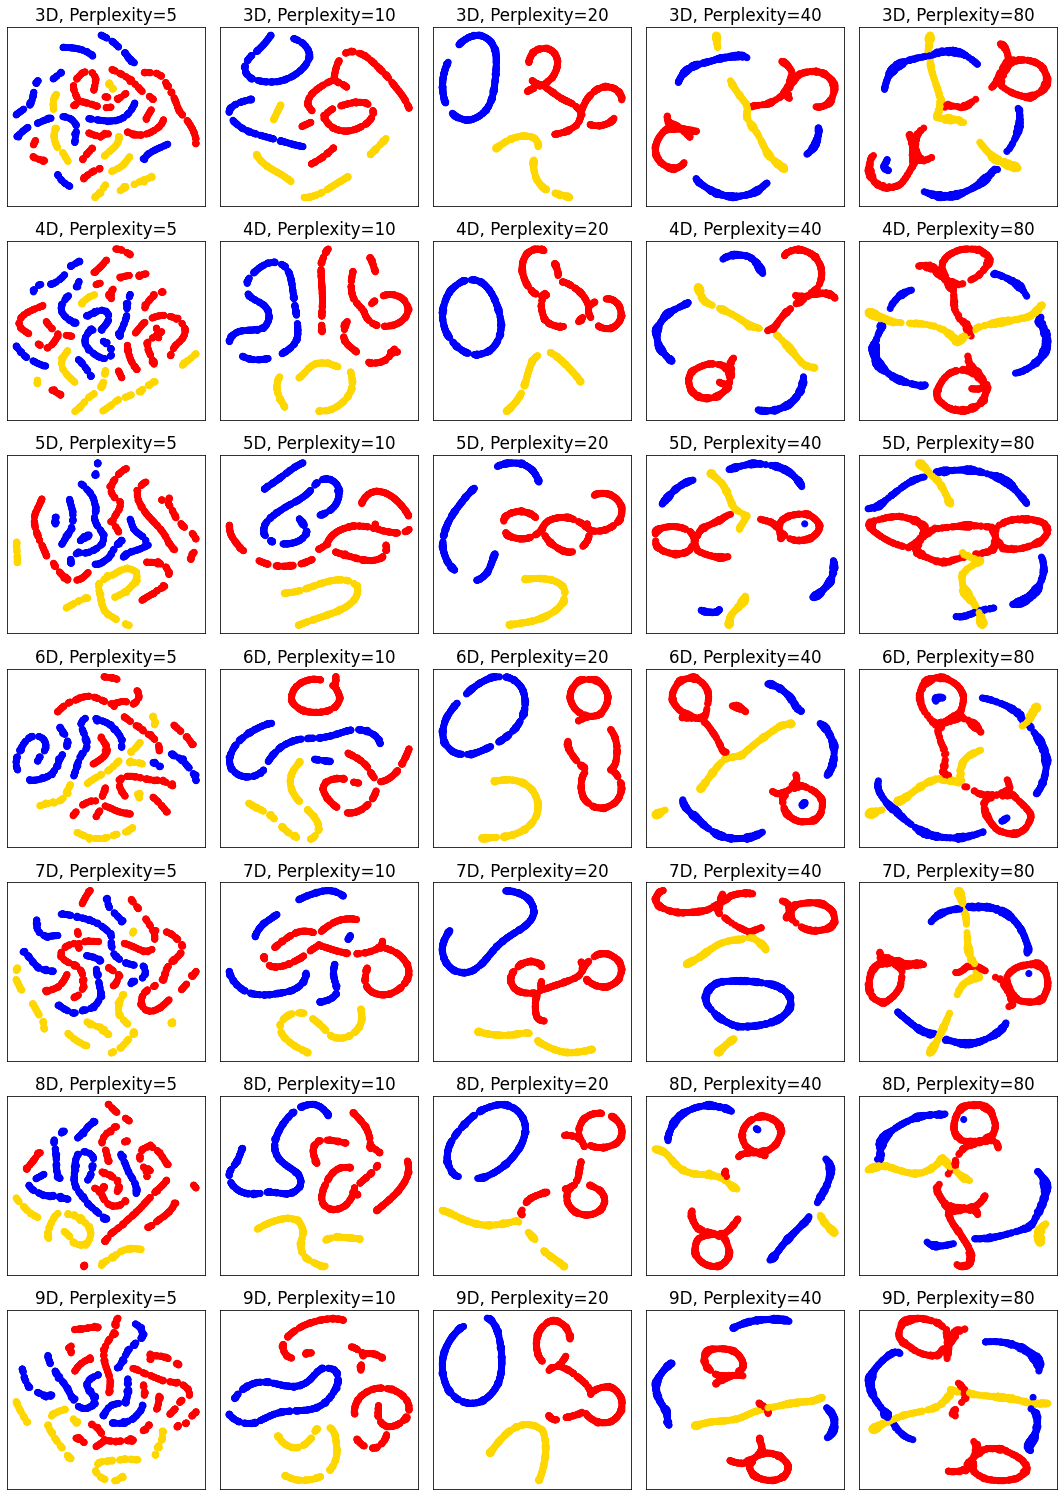

In [ ]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
Ndim = len(L_list)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(Ndim, Np, figsize=(3*Np, 3*Np*Ndim/5))

X_all = [[] for _ in range(Ndim)]
for j, dim in enumerate(L_list):
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity,
                             learning_rate='auto')
        Y = tsne.fit_transform(data_x[dim])

        ax.set_title(f"{dim}D, Perplexity={perplexity}")
        ax.scatter(Y[:, 0], Y[:, 1], c=data_y[dim],cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all[j].append(Y)

fig.tight_layout()
plt.show()

From the plots above it is not possible to find a correlation between t-SNE visualization and the number of dimensions. As expected, the most relevant parameter is `perplexity`, which is discussed in point 2 of the notebook. Thus, the algorithm is able to represent the original 3D data with noise along the other L-3 dimensions, with little to no loss of information. However, we could expect a worse visualization with different types of spatial arrangements (e.g., encoding the 3D data into a manifold in n-dimensions).

### DBSCAN: find labels by applying clustering

We apply clustering to the original data, and then we apply t-SNE to visualize them in the 2D space.

Even though DBSCAN has few parameters, testing every combination of parameters for each input dimension would be too computationally demanding. So, as a first step, let's see what happens in the base case with 3 dimensions.

The perplexity value of t-SNE visualization is fixed at the value of 20 to simplify the discussion. 

In [ ]:
# examine X_all
X_all = np.array(X_all)
print(X_all.shape)

(7, 5, 1000, 2)


X_all has 7 rows corresponding to the input dimensions and 5 columns, one for each perplexity. Each element is a 1000x2 matrix.

3D case
Perplexity=20


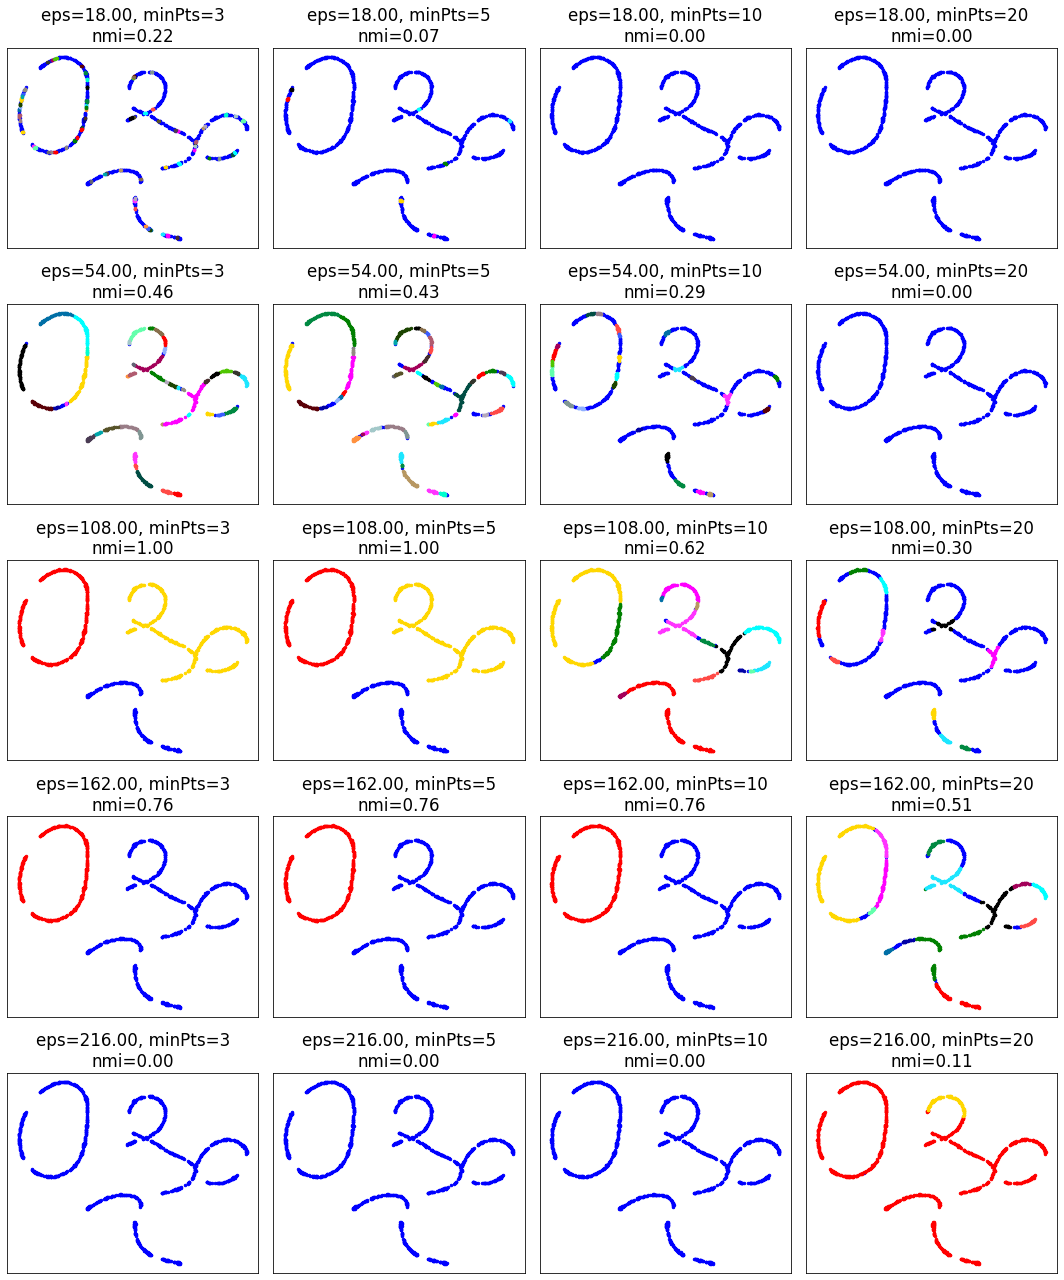

In [ ]:
np.random.seed(12345)

dim = 3 # dimension considered
print(f"{dim}D case")

visual = 3
print(f"Perplexity={perplexities[visual-1]}")

# select data
X2D = X_all[dim-3,visual-1] # the 3rd is the best visualization above of 3D data
X = data_x[dim]
y_true = data_y[dim]

# esp range
r = int(mean_min_dist[dim])
eps_range = [r,3*r,6*r,9*r,12*r]

# min points range
min_sample_range = [3,5,10,20]

# grid search
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        # DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_

        # NMI
        nmi=NMI(y_hat, y_true)

        # PLOTTING
        plotting_ax(X2D,y_hat,ax[i,j])
        ax[i,j].tick_params(left=False,bottom=False)
        ax[i,j].xaxis.set_major_formatter(NullFormatter())
        ax[i,j].yaxis.set_major_formatter(NullFormatter())
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))

plt.tight_layout()
plt.show()


Now, let's consider the 3 best architectures (i.e., the three best combinations of `eps` and `minPts` with lower NMI) and see how they behave when we consider data with additional dimensions.

Perplexity=20


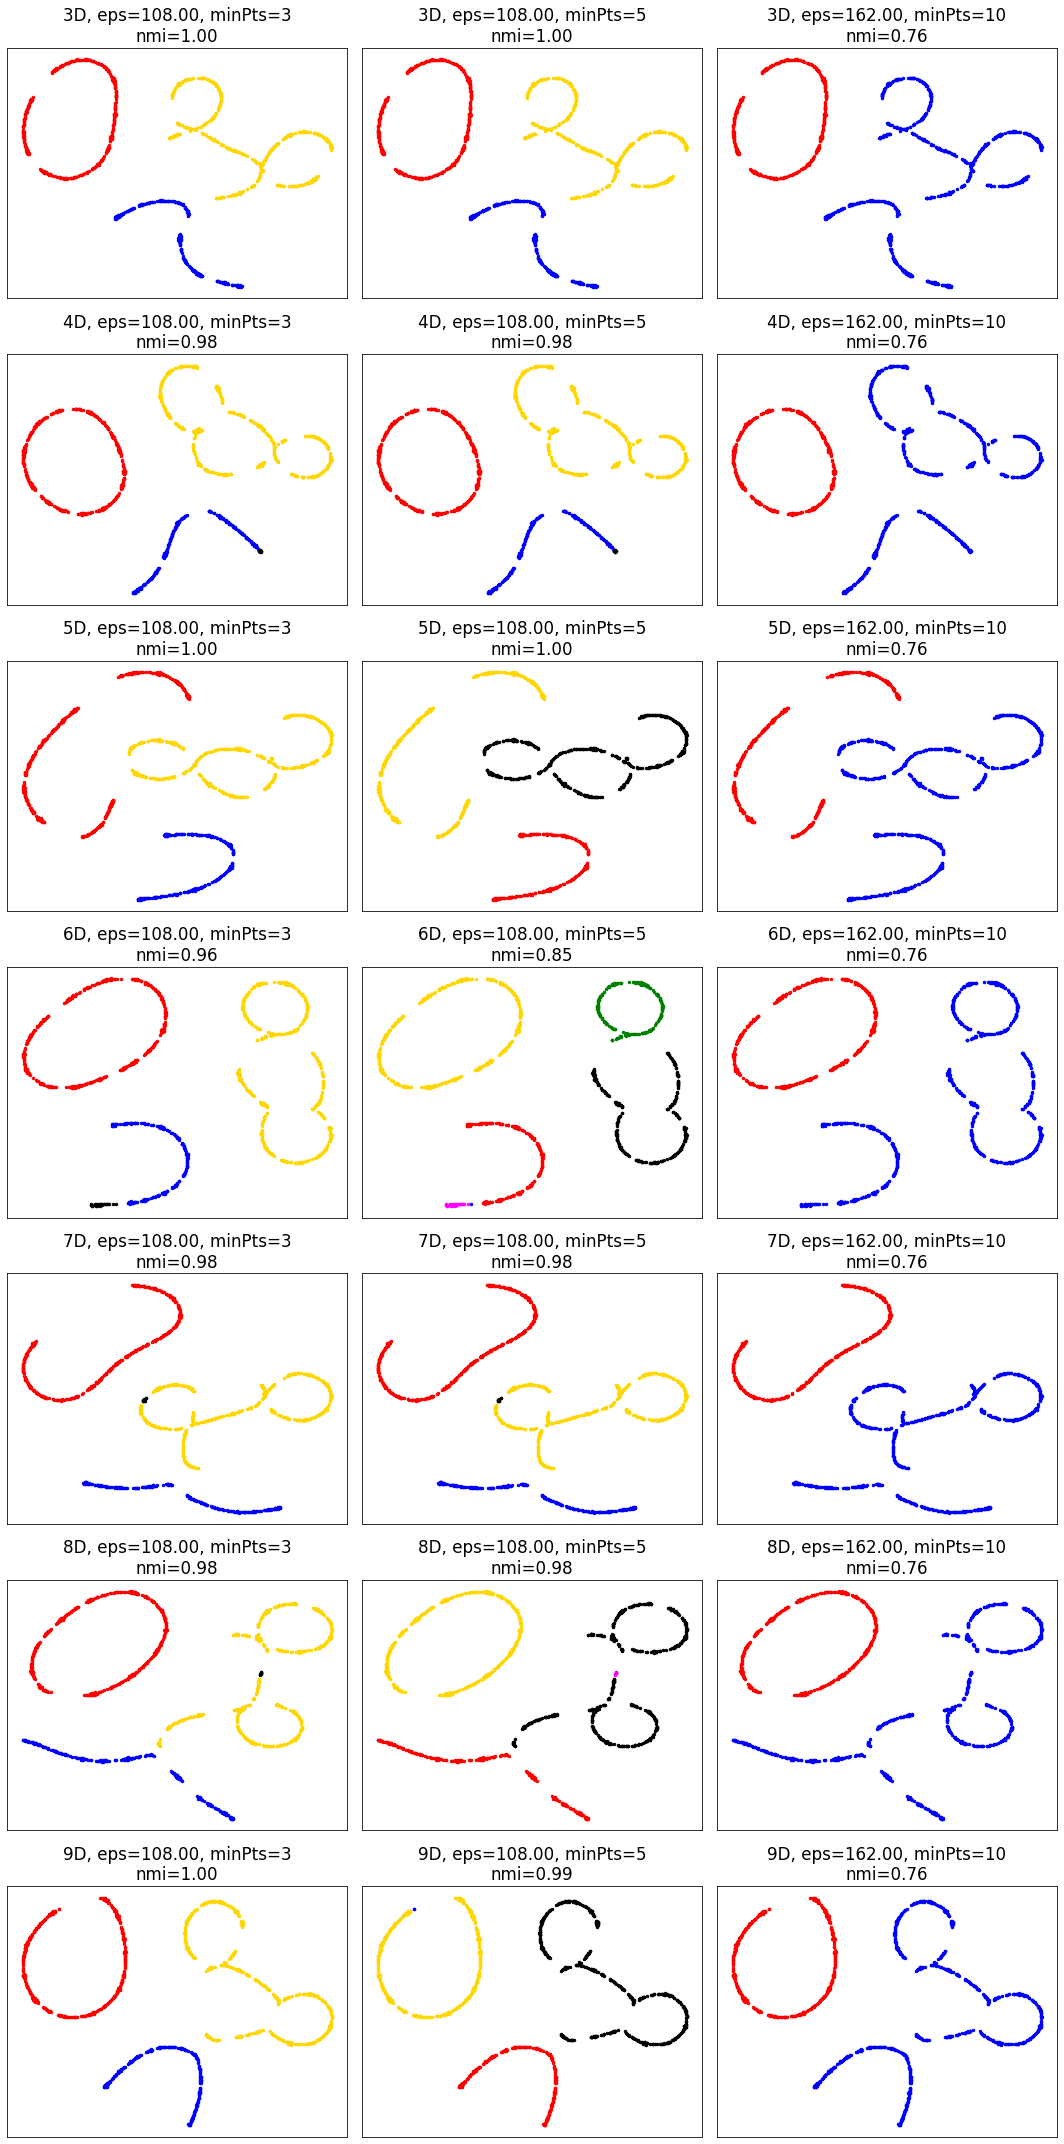

In [ ]:
architectures = [[108, 3], [108, 5], [162, 10]]  #[eps, minPts]

visual = 3
print(f"Perplexity={perplexities[visual-1]}")

# esp range
r = int(mean_min_dist[dim])
eps_range = [r,3*r,6*r,9*r,12*r]

# min points range
min_sample_range = [3,5,10,20]

fig, ax = plt.subplots(Ndim, len(architectures), figsize=(15,30))

for i, dim in enumerate(L_list):
    # SELECT DATA
    X2D = X_all[dim-3,visual-1] # the 3rd is the best visualization above of 3D data
    X = data_x[dim]
    y_true = data_y[dim]

    for j, [eps, min_samples] in enumerate(architectures):
        
        # DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_

        # NMI
        nmi=NMI(y_hat, y_true)

        # PLOTTING
        plotting_ax(X2D,y_hat,ax[i,j])
        ax[i,j].tick_params(left=False,bottom=False)
        ax[i,j].xaxis.set_major_formatter(NullFormatter())
        ax[i,j].yaxis.set_major_formatter(NullFormatter())
        ax[i,j].set_title('%iD, eps=%.2f, minPts=%i\nnmi=%.2f'%(dim,eps,min_samples,nmi))

plt.tight_layout()
plt.show()


As the number of dimensions increases, the average number of clusters found by the algorithm also increases. In fact, by fixing a value of `eps` we are also fixing the maximum distance two points can have to be considered in the same cluster. Since this distance is independent on the numer of dimensions, in high-dimensional spaces it is more likely that distant points (originally in the same cluster) are associated to different clusters. Even if from the 2D projection shown above the clusters are clearly recognizable, the clustering algorithm considers also the remaining dimensions and the final result is affected by them.

However, this problem can be overcome by considering a specific `eps` for each space dimensionality. The `eps` choice for each data dimensionality can be found either by computing the typical minimum distance between points or by the tuning procedure described in point 3 of this notebook.

## 2. The role of “perplexity” in t-SNE

_Perplexity says (loosely) how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has_ (https://distill.pub/2016/misread-tsne/).

- **Provide your explanation on the patterns observed by varying the perplexity of t-SNE.** <br>
    The perplexity parameters states how much the algorithm has to be sensible to local density gradients. A perplexity too much different from the expected value of close neighbors induces a sigma that differs from the characteristic distances between data points, and thus it does not visualize correctly the structure of data. On one side, with a too small perplexity the algorithm recognizes only local structures but it cannot connect in the proper way the global ones. On the other hand, with a too large perplexity the algorithm causes an overlap of data and it makes difficult a following separation of data into clusters.
    However, it is interesting to notice how different perplexities can help to study the topology of data (the webpage ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/) shows interactively this important aspect). In particular, while intermediate perplexities are the ideal choice to perform a successive clustering on processed data, large perplexities help to understand how different clusters are connected.


- **Do the pattern vary if t-SNE is initialized by using principal component analysis (init=’pca’)?** <br>
    As we can see from the plots below, all the patterns recognized by t-SNE and initialized with PCA are similar (if not completely equivalent) for different dimensionsalities of the space.
    The explanation of this fact may concern the ability of PCA to remove the non-relevant directions with a rotation in the full space followed by a projection on the most relevant directions. Since in our data the additional dimensions are represented by noise, PCA initialization removes the noise for every space dimensionalities and thus the final representations are equivalent when the perplexity is fixed.
    However, in our case the results of t-SNE preceeded by the PCA initialization are harder to interpret so we keep considering only random initialization.

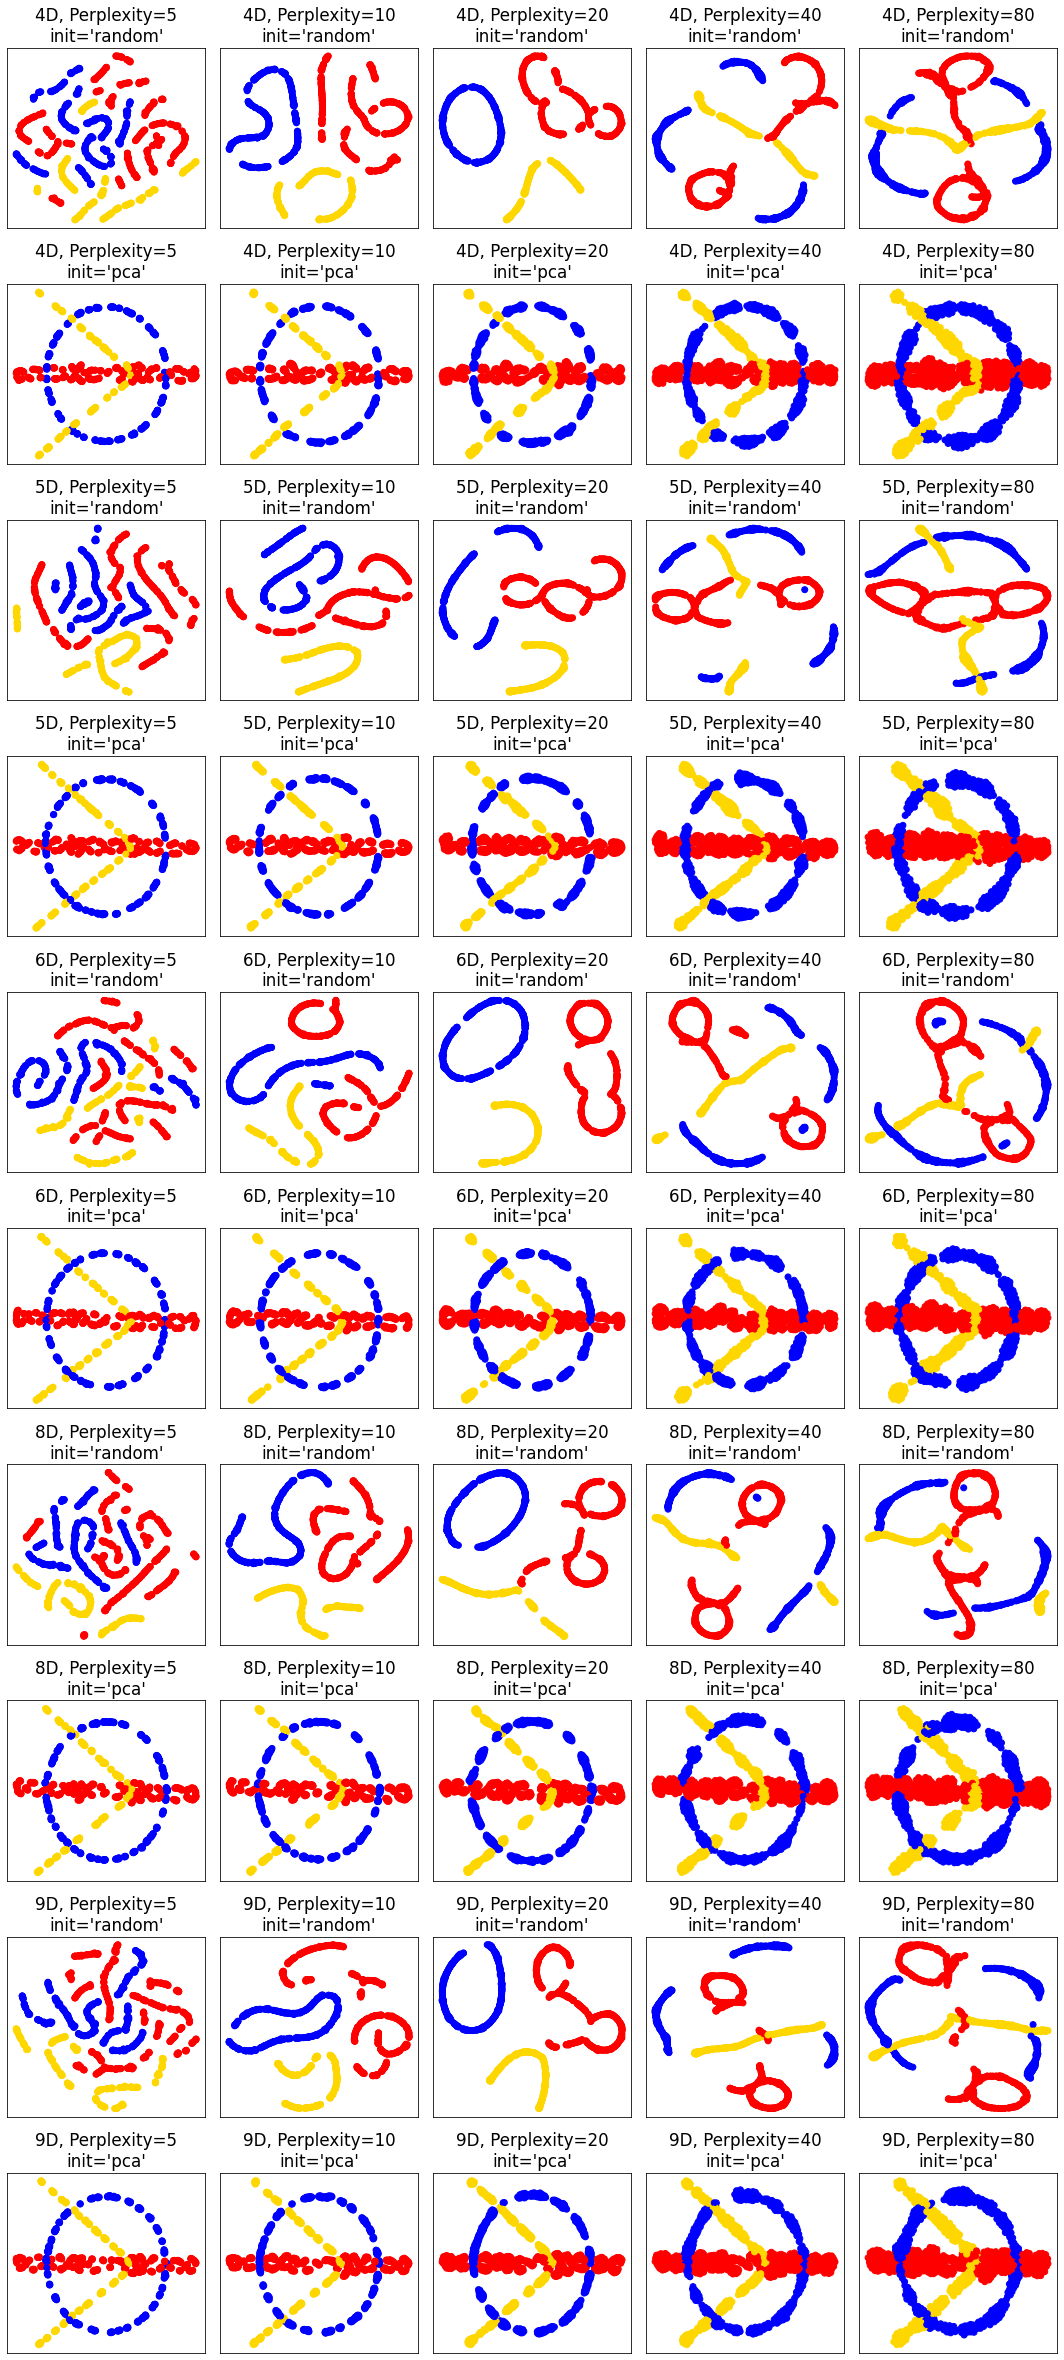

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
dim = [4,5,6,8,9] # dimension considered

perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(10, Np, figsize=(15, 33))

X_all = [[],[]]

for i, d in zip ( range(Np) , dim):

    for j, p in enumerate(perplexities):

        
        # random initialization
        ax = subplots[2*i, j]
        #t0 = time()
        tsne = manifold.TSNE(n_components=2, init='random',
                                random_state=0, perplexity=p,
                                learning_rate='auto')
        Y = tsne.fit_transform(data_x[d])

        ax.set_title(f"{d}D, Perplexity={p}\ninit='random'")
        ax.scatter(Y[:, 0], Y[:, 1], c=data_y[d],cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all[0].append(Y)


        # PCA initialization
        ax = subplots[2*i +1 , j]
        #t0 = time()
        tsne = manifold.TSNE(n_components=2, init='pca',
                                random_state=0, perplexity=p,
                                learning_rate='auto')
        Y = tsne.fit_transform(data_x[d])

        ax.set_title(f"{d}D, Perplexity={p}\ninit='pca'")
        ax.scatter(Y[:, 0], Y[:, 1], c=data_y[d],cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all[1].append(Y)

fig.tight_layout()
plt.show()

## 3. Tuning of “eps” and “minPts” in DBSCAN algorithm for clustering
**The grid with several values of “eps” and “minPts” shows that the normalized mutual information (NMI) between true and predicted clusters is varying. Is there a correlation between these two parameters in providing a high NMI? Is there a way of guessing good values for “eps” and “minPts”?**
A too small value of `eps` induces the algorithm to find small clusters (if `minPts` is small) or a unique cluster for all the dataset (if `minPts` is large). A too large value of `eps` combined with a small value of `minPts` also induces the creation of a unique cluster. Interestingly, when both `eps` and `minPts` are large the algorithm finds more than one cluster, but the result is still far from the optimal clustering.
For what concerns intermediate values of these two parameters, the variation of `eps` induces a greater change in NMI while the choice of `minPts` plays a minor role as soon as `eps` is properly tuned.

Summarizing, to choose the best parameters it is sufficient to fix a reasonable value for the parameter `minPts` (i.e., around 5) and then to tune `eps` accordingly. The tuning of `eps` is described in the following cell.

### Tuning of "eps" given "minPts"

The starting point is to choose a value of `minPts`. Then, for each point we compute the distance to its minPts-th nearest neighbor and we sort them on descending order. By plotting these distances it is possible to discriminate between isolated and non-isolated points, and a particular choice of the threshold distance (i.e., the `eps` parameters) divides the dataset into isolated and non-isolated points.

This procedure was first proposed in Section 4.2 of the [original paper](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf).

In [ ]:
def k_dist(x, k):
    """
    Function to compute, for each point of a dataset x, the distance to its k-nearest neighbor
    (the point itself is considered its own 0-nearest neighbor)
    x: input data of shape (n_samples_, n_dim_,) 
    k: order of the neighbor-point to which we compute the distance

    k_dist_: vector of distances of shape (n_samples_,) for each point of the dataset
    """

    # compute and sort distance matrix
    dist_matrix = spatial.distance_matrix(x, x)
    sorted_dist_matrix = np.sort(dist_matrix, axis=1)
 
    return sorted_dist_matrix[:,k]

### Typical distances as a function of k-th neighbour (3D case)
The plot below shows the mean distances, computed over all the points, as a function of the neighbor order. The tangent-like shape of this plot is typical and it can be found also in the k-dist plot. However not fundamental for the dierct computation of `eps`, this plot is helpful to inspect the properties of the dataset.

3D case


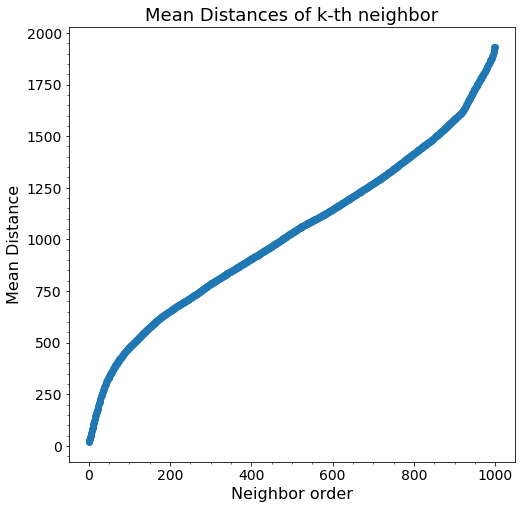

In [ ]:
dim = 3 # dimension considered
print(f"{dim}D case")

# maximum number of considered minPts
max_minpts = 999

# mean distances w.r.t. k-neighbor
mean_kdist = np.mean(k_dist(data_x[dim], np.arange(1, max_minpts+1)), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(np.arange(1, max_minpts+1), mean_kdist)
ax.set_xlabel("Neighbor order (k)", fontsize=16)
ax.set_ylabel("Mean Distance", fontsize=16)
ax.set_title("Mean Distances to the k-th neighbor", fontsize=18)
ax.minorticks_on()


fig.show()

### k-dist plots for different neighbor orders (3D case)

These plots perform the aforementioned discrimination between isolated and non-isolated points. For a fixed value of the k-th neighbor to consider, the distances sorted in descending order are plotted (the x-axis is just to count the number of points that are considered isolated).
The first part of the plot shows the distances to the considered neighbor of the most isolated points. In this region, the derivative w.r.t. N is large because only few points have very high distances. After this region, the derivative of the plot drastically decreases because the non-isolated points are near to each other and many points have similar distances to their k-th neighbor.

By choosing a threshold value for N, in DBSCAN algorithm we can manually discriminate the most isolated points by choosing as `eps` the value of the distance corresponding to the threshold N. With this choice the points belonging to the first region are considered as noise by construction.

3D case


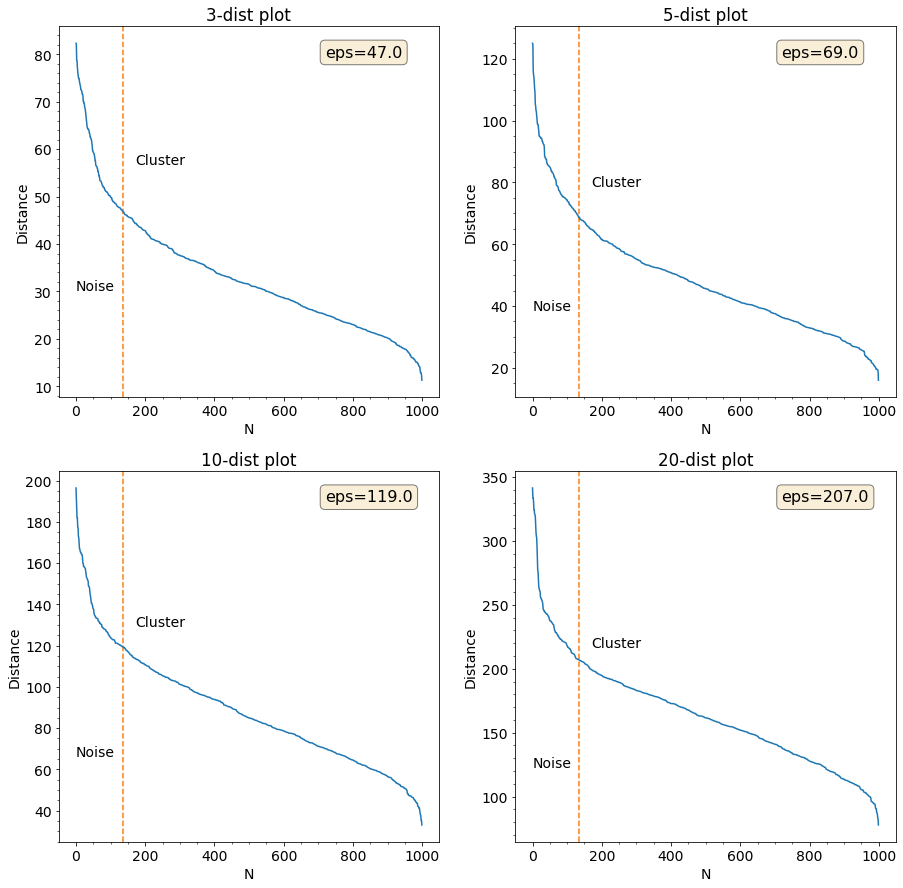

In [ ]:
dim = 3 # dimension considered
print(f"{dim}D case")

# min points range
min_sample_range = [3,5,10,20]


fig, ax = plt.subplots(2, int(len(min_sample_range)/2), figsize=(15,15))

for minpt, axs in zip(min_sample_range, np.ravel(ax)):

    # array of sorted point w.r.t. minpt-nearest neighbor
    # point with high minpt-distance are likely to be outliers
    sorted_minpt_NN = np.sort(k_dist(data_x[dim], minpt))[::-1]

    axs.set_title(f"{minpt}-dist plot")
    axs.set_xlabel("N")
    axs.set_ylabel("Distance")
    axs.axvline(x=135, ymin=0 , ymax=350 , ls="--" , color="C1")
    axs.text(x=170, y=sorted_minpt_NN[135] + 10 , s="Cluster")
    axs.text(x=0, y=sorted_minpt_NN[900] + 10 , s="Noise")

    axs.minorticks_on()
    axs.plot(sorted_minpt_NN)

    axs.text(x=0.70, y=0.95, s=f'eps={round(sorted_minpt_NN[135],0)}', transform=axs.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))




## 4. VERY VERY OPTIONAL: t-SNE for clustering?

**Task:**
We know that t-SNE is stochastic and may converge to a different result if the random seed is varied. Moreover, visibly the result depends also on perplexity. Possibly, by checking which points are more likely to stay close to each other in different runs of t-SNE, one is able to assess the connectivity of the points in the original space, with implications for their clustering.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>